In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple, Set

GRID_SIZE = 9
BLOCK_LENGTH = 3
h_offset = 6
v_offset = 3

def normalize(v):
    sx, sy = np.sign(v[0]), np.sign(v[1])
    return (int(sx), int(sy))

def get_block_direction(a, b, mode):
    """Calculates the block's orientation vector relative to the line ax+by+c=0."""
    if mode == 1:  # parallel to line
        direction_vector = (-b, a)
    elif mode == 0:  # perpendicular to line
        direction_vector = (a, b)
    else:
        raise ValueError("mode must be 0 or 1")
    norm = np.linalg.norm(direction_vector)
    return tuple(c / norm for c in direction_vector) if norm > 0 else (0, 0)



def sample_blocks_for_line(
    a: float,
    b: float,
    c: float,
    mode: str,
    min_dist_ax: float,
    num_points: int = 1,
    sampling_mode: str = "random",
) -> List[Tuple[Tuple[float, float], Tuple[int, int]]]:
    """
    Samples block centers along a line defined by ax + by + c = 0 on a grid.

    Args:
        a, b, c: Coefficients of the line equation.
        mode: Mode used to determine block direction.
        min_dist_ax: The minimum required distance between sampled points.
        num_points: The desired number of points to sample.
        h_offset, v_offset: Offsets to apply to the final center coordinates.

    Returns:
        A list of tuples, where each tuple contains a center coordinate and a direction vector.
    """
    dy, dx = get_block_direction(a, b, mode)

    # --- Refactored Candidate Generation ---
    candidate_centers: Set[Tuple[float, float]] = set()
    grid_indices = np.arange(GRID_SIZE)
    coords = grid_indices + 0.5

    # Intersections with horizontal grid lines (solving for x)
    if abs(a) > 1e-9:
        x_intersections = -(b * coords + c) / a
        for i, ix in enumerate(x_intersections):
            cx = np.round(ix - 0.5) + 0.5
            if 0 <= cx < GRID_SIZE:
                candidate_centers.add((cx, coords[i]))

    # Intersections with vertical grid lines (solving for y)
    if abs(b) > 1e-9:
        y_intersections = -(a * coords + c) / b
        for i, iy in enumerate(y_intersections):
            cy = np.round(iy - 0.5) + 0.5
            if 0 <= cy < GRID_SIZE:
                candidate_centers.add((coords[i], cy))

    # --- Filter for valid centers ---
    potential_centers = [
        (cx, cy) for cx, cy in candidate_centers
        if is_valid_block_center(cy, cx, dy, dx)
    ]

    # Sort the valid centers along the line's direction vector.
    # The line direction (dx, -dy) is perpendicular to the block's normal (dy, dx).
    if sampling_mode == 'uniform':
      sort_key = lambda p: p[0] * dx - p[1] * dy
      potential_centers.sort(key=sort_key)
    elif sampling_mode == 'random':
      np.random.shuffle(potential_centers)
    else:
      raise ValueError("sampling_mode must be 'uniform' or 'random'")

    # --- Select final points ensuring minimum distance ---
    centers: List[Tuple[Tuple[float, float], Tuple[int, int]]] = []
    for cx, cy in potential_centers:
        if len(centers) >= num_points:
            break

        is_far_enough = all(
            ((cx - (ecx - h_offset))**2 + (cy - (ecy - v_offset))**2) >= min_dist_ax**2
            for (ecx, ecy), _ in centers
        )

        if is_far_enough:
            # Applying the offsets to the selected point
            final_center = (cx + h_offset, cy + v_offset)
            # The direction vector is (dx, -dy), which might be the normal vector. This is kept as is.
            direction = (dx, -dy)
            centers.append((final_center, direction))

    return centers


def is_valid_block_center(cy, cx, dy, dx):
    half = BLOCK_LENGTH // 2
    for i in range(-half, half+1):
        y = cy + i*dy
        x = cx + i*dx
        if not (0 <= y < GRID_SIZE and 0 <= x < GRID_SIZE):
            return False
    return True



def visualize_lines_with_arrows(lines, draw_line=True, sampling_mode='uniform'):
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xlim(0, h_offset + GRID_SIZE + 3)
    ax.set_ylim(0, v_offset + GRID_SIZE + 3)
    ax.set_aspect('equal')
    ax.set_xticks(np.arange(h_offset, h_offset + GRID_SIZE + 1, 1))
    ax.set_yticks(np.arange(v_offset, v_offset + GRID_SIZE + 1, 1))
    ax.grid(True, which='both', color='lightgray', linewidth=0.5)
    ax.set_title("3×1 Blocks Parallel/Perpendicular to Lines")

    colors = plt.cm.get_cmap('tab10', len(lines))

    for i, (a, b, c, label, mode, max_dist, num_points) in enumerate(lines):
        centers = sample_blocks_for_line(a, b, c, mode, max_dist, num_points=num_points, sampling_mode=sampling_mode)

        # Plot line
        if draw_line:
          xs = np.linspace(0, GRID_SIZE, 500)
          ys = (-a * xs - c) / b
          ax.plot(xs + h_offset, ys + v_offset, color=colors(i), linestyle='--')


        # Plot centers and arrows
        for (cx, cy), (dx, dy) in centers:
            ax.plot(cx, cy, 'o', color=colors(i))
            ax.arrow(cx, cy, 0.3 * dx, 0.3 * dy,
                     head_width=0.12, head_length=0.15,
                     fc=colors(i), ec=colors(i))

    # Add four corners of the box
    box_corners = [
        (1,4),
        (5,4),
        (5,8),
        (1,8)
    ]
    for (cx, cy) in box_corners:
        ax.plot(cx, cy, 'x', color='black', markersize=8)

    # ax.legend(loc='upper right', fontsize=8)
    # plt.gca().invert_yaxis()
    plt.show()

/tmp/ipython-input-19-2621800946.py:130: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(lines))
/tmp/ipython-input-19-2621800946.py:138: RuntimeWarning: divide by zero encountered in divide
  ys = (-a * xs - c) / b


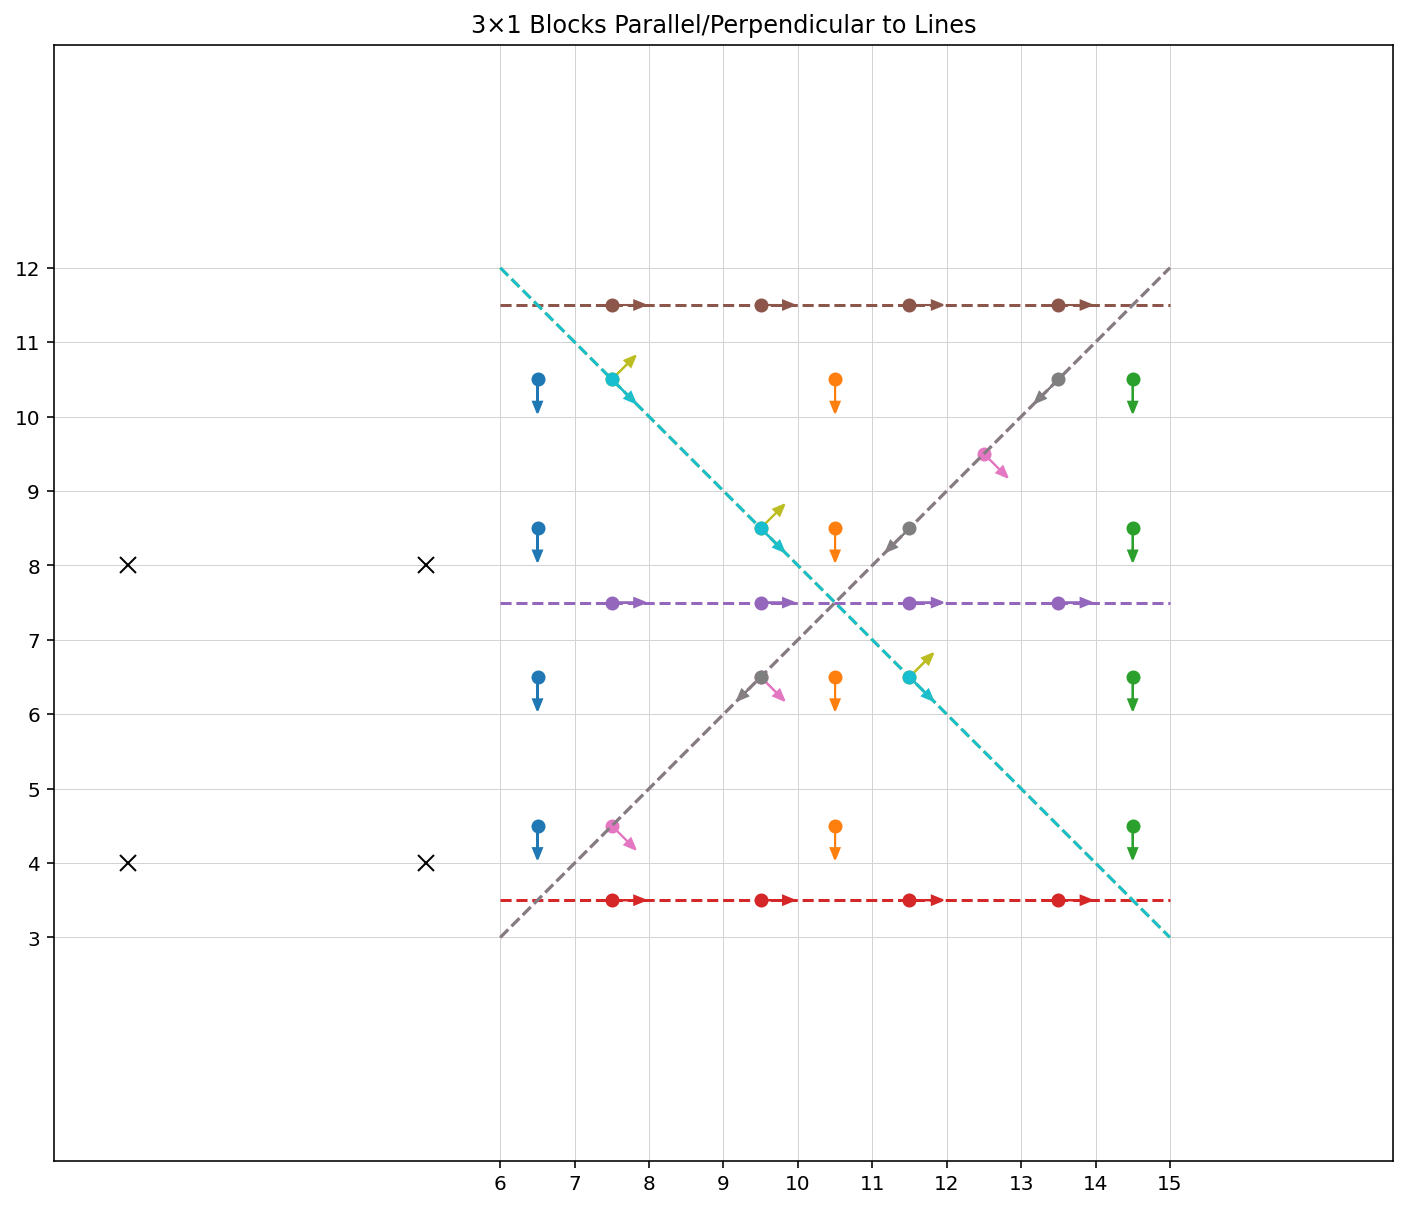

In [ ]:
# Run visualization
import matplotlib.pyplot as plt
import numpy as np

GRID_SIZE = 9
BLOCK_LENGTH = 3
h_offset = 6
v_offset = 3

# Lines: (a, b, c, label, orientation_mode)
lines = [
    (1, 0, -.5, f"x=-.5", 0, 1.5, 4),
    (1, 0, -GRID_SIZE/2, f"x=-GRID_SIZE/2", 0, 1.5, 4),
    (1, 0, -GRID_SIZE + .5, f"x={GRID_SIZE}", 0, 1.5, 4),

    (0, 1, -.5, f"y=0", 0, 1.5, 4),
    (0, 1, -GRID_SIZE/2, f"y=-GRID_SIZE/2", 0, 1.5, 4),

    (0, 1, -GRID_SIZE + .5, f"y={GRID_SIZE}", 0, 1.5, 4),

    (1, -1, 0, "x = y", 1, 1.5, 3),
    (1, -1, 0, "x = y", 0, 1.5, 3),

    (1, 1, -GRID_SIZE, "x = -y + 8", 1, 1.5, 3),
    (1, 1, -GRID_SIZE, "x = -y + 8", 0, 1.5, 3)

    ]


visualize_lines_with_arrows(lines, sampling_mode='uniform')

In [ ]:
import itertools
import random
import numpy as np
from typing import List, Tuple


def sample_grid_midpoints(g: int, k: int) -> List[Tuple[float, float]]:
    """
    Samples k unique random midpoint coordinates from a g x g grid.
    """
    total_blocks = g * g
    if k > total_blocks:
        raise ValueError(
            f"Cannot sample {k} items. The grid only has {total_blocks} blocks."
        )

    # Create all possible (row, col) integer indices for the grid cells
    all_indices = list(itertools.product(range(g), repeat=2))

    # Randomly sample k unique indices without replacement
    sampled_indices = random.sample(all_indices, k)

    # Convert integer indices (e.g., 0, 1, 2...) to float midpoints (0.5, 1.5, 2.5...)
    return [(i + 0.5, j + 0.5) for i, j in sampled_indices]



def generate_random_lines(num_lines: int,
                          num_points_per_line: int,
                          min_dist: float,
                          seed: int = 42) -> List[Tuple]:
    """
    Generates configurations for random lines to be passed to a sampling function.

    Each line is defined by passing through a random grid midpoint at one of several
    fixed angles. This function returns the parameters needed to sample points,
    not the points themselves.

    Args:
        num_lines: The number of line configurations to generate.
        num_points_per_line: The number of points to eventually sample on each line.
        min_dist: The minimum distance between sampled points on a line.
        seed: A random seed for reproducibility.

    Returns:
        A list of tuples. Each tuple is a configuration for one line:
        (a, b, c, label, mode, min_dist, num_points_per_line)
    """
    np.random.seed(seed)
    random.seed(seed) # Also seed the `random` module for `random.sample`

    line_configs = []
    angles = [0, 45, 90, 135] # Define the set of angles for the lines

    # Get a set of unique starting points for our lines
    try:
        xy_cells = sample_grid_midpoints(GRID_SIZE, num_lines)
    except ValueError as e:
        print(f"Error: {e}")
        return []

    for x, y in xy_cells:
        # 1. Choose a random angle and calculate line parameters `a, b, c`
        angle_deg = np.random.choice(angles)
        angle_rad = np.deg2rad(angle_deg)
        a = np.sin(angle_rad)
        b = -np.cos(angle_rad)
        c = -a * x - b * y # Calculate c to ensure the line passes through (x, y)

        # 2. Randomly choose a block orientation ('H' or 'V')
        # This format is more explicit and works with the previous code.
        mode = np.random.choice([0, 1])

        # 3. Create a descriptive label and append the full configuration
        label = f"Line through ({x}, {y}) at {angle_deg}°"
        line_configs.append((a, b, c, label, mode, min_dist, num_points_per_line))

    return line_configs

/tmp/ipython-input-19-2621800946.py:130: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(lines))


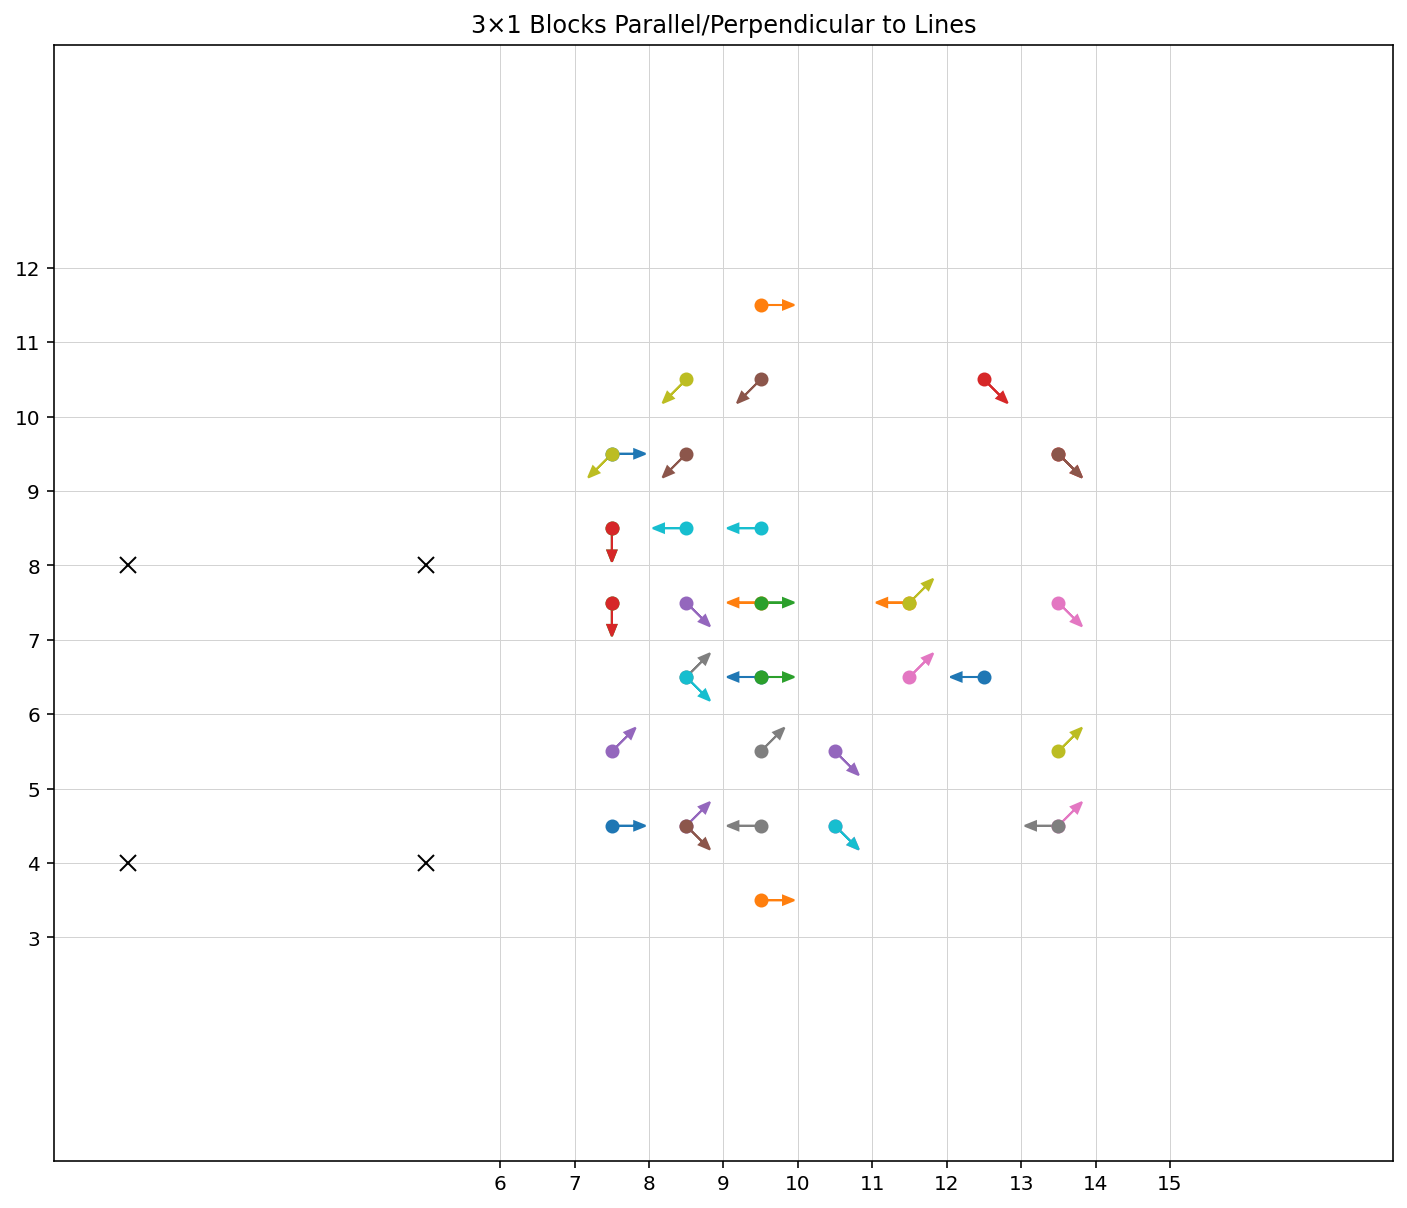

In [ ]:
visualize_lines_with_arrows(generate_random_lines(20, 2, 1), draw_line=False, sampling_mode='random')

In [ ]:
poses = visualize_lines_with_arrows(generate_random_lines(20, 2, 1), draw_line=False, sampling_mode='random')
print(poses)